# Documentación


Para la detección de giro lo que se hizo fue primero importar el video y tomar un frame de referencia para generar después una zona de interés.


Una de las funciones que se utilizaron fue la de `binarizacion(imagen)`, la cual toma un frame como input y genera un filtro grausiano y un threshold para binarizar la imagen a colores negro y blanco. El cual indica la carretera que se va a analizar.


Posterior a eso se hizo otra función, ya que meter tomda la imagen al análisis anterior generaría bastantes conflictos por las zonas que no entran en nuestro estudio, por lo mismo generamos otra función llamada `area_interes(imagen)`, la cual también toma una imagen como input, con unos `x1`, `x2`, `x3` y `x4` que son esquinas de la zona de interés y lo modifica a formar un rectángulo donde abarque solo la información dentro de este rectángulo.

Otra función que usamos fue `punto_medio(imagen)`, esta analiza la imagen binarizada y encuentra el punto medio de la imagen analizada dependiendo de la concentración de pixeles blancos que encuentre en la imagen que toma de input


Por último se usaron dos funciones `sum_izquierda(imagen, valor_punto_medio)` y `sum_derecha(imagen, valor_punto_medio)`. Estas lo que hacen es sumar los pixeles blancos que se encuentran del lado izquiero y derecho respectivamente de la figura. Esto es útil para depsués usar un parámetro delta que nos sirve para identificar si la carretera está con dirección a la izquierda o a la derecha.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import time

# Actividad 1. Detección de giro

In [2]:
video = cv.VideoCapture("videos/carretera_nueva.mp4")
i = 0
while(video.isOpened() and i < 1):
    ret, frame = video.read()
    if ret == False:
        break
    cv.imwrite('figuras/imagen1_' + str(i) + '.jpg', frame)
    i += 1
video.release()
cv.destroyAllWindows()

In [3]:
def binarizacion(imagen):
    img = cv.cvtColor(imagen, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_gauss = cv.GaussianBlur(img_gray, (3, 3), 0)
    thr, img_thr = cv.threshold(img_gauss, 160, 255, cv.THRESH_BINARY)
    alto = img.shape[0]
    ancho = img.shape[1]
    ratio = 0.2
    img_r = cv.resize(img_thr, (480, 240), interpolation = cv.INTER_NEAREST)
    return(img_r)

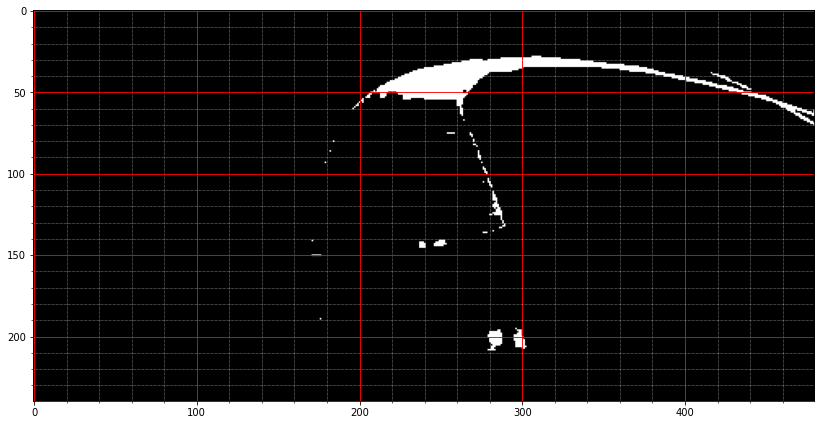

In [4]:
#probar la binarizacion en una imagen del video
img = cv.imread('figuras/imagen1_0.jpg')
img_bin = binarizacion(img)
fig, ax = plt.subplots(figsize = (14, 14))
ax.imshow(img_bin, cmap = 'gray')
ax.minorticks_on()
ax.grid(which = 'major', linestyle = '-', linewidth = '0.9', color = 'red')
ax.grid(which = 'minor', linestyle = ':', linewidth = '0.5', color = 'white')

In [5]:
#Poligono de área de interés
x1 = (200, 40)
x2 = (280, 40)
x3 = (190, 100)
x4 = (290, 100)

pts_poligono = np.array([x1, x2, x3, x4], np.int32)
pts_poligono = pts_poligono.reshape((-1, 1, 2))

In [6]:
#Funcion de área de interés
def area_interes(imagen):
    pts1 = np.float32([x1, x2, x3, x4])
    pts2 = np.float32([[0, 0], [480, 0], [0, 240], [480, 240]])
    matrix = cv.getPerspectiveTransform(pts1, pts2)
    img_warp = cv.warpPerspective(imagen, matrix, (480, 240))
    return (img_warp)

In [7]:
#Función para encontrar el punto medio
def punto_medio(imagen):
    img_cercana = imagen[220:, :]
    suma_columnas = img_cercana.sum(axis = 0)
    x_pos = np.arange(len(suma_columnas))
    mid_point = int(np.dot(x_pos, suma_columnas) / np.sum(suma_columnas))
    return mid_point

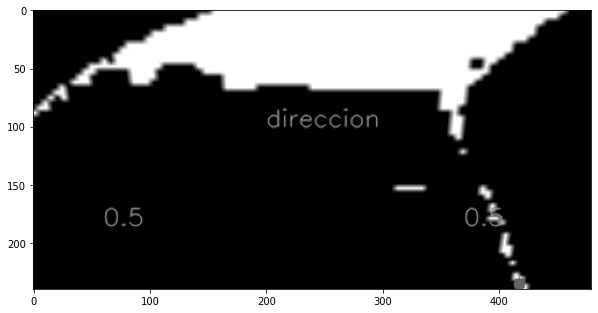

In [8]:
#Aplicamos todas las funciones
img = cv.imread('figuras/imagen1_0.jpg')
img_bin = binarizacion(img)
img_interes = area_interes(img_bin)
mid_point = punto_medio(img_interes)

#textos
text1 = str(0.50)
text2 = str(0.50)
text3 = 'direccion'

#agregamos el tipo de fuente
font = cv.FONT_HERSHEY_SIMPLEX

#origen de cada texto
org1 = (60, 185)
org2 = (370, 185)
org3 = (200, 100)

#tamaño 
fontScale = 0.7

#color de la fuente
color = (150, 150, 150)

#grosor
thickness = 1

#usamos la funcion 'cv.putText()' que permitirá agregar texto
cv.putText(img_interes, text1, org1, font, fontScale,
              color, thickness, cv.LINE_AA, False)
cv.putText(img_interes, text2, org2, font, fontScale,
              color, thickness, cv.LINE_AA, False)
cv.putText(img_interes, text3, org3, font, fontScale,
              color, thickness, cv.LINE_AA, False)

plt.figure(figsize = (10, 7))
cv.circle(img_interes, (mid_point, 235), 5, (100, 100, 100), -1);
plt.imshow(img_interes, cmap = 'gray')
plt.show()

In [9]:
#Funcion suma normalizada izquierda
def sum_izquierda(imagen, valor_punto_medio):
    return np.round(np.sum(imagen[:, :valor_punto_medio].sum(axis=0))/(255*240*480), 2)

In [10]:
#Funcion suma normalizada derecha
def sum_derecha(imagen, valor_punto_medio):
    return np.round(np.sum(imagen[:, valor_punto_medio:].sum(axis=0))/(255*240*480), 2)

In [11]:
sum_izquierda(img_interes, mid_point)

0.19

In [12]:
sum_derecha(img_interes, mid_point)

0.01

In [13]:
#Implementacion de la dirección de giro en el video 

video = cv.VideoCapture('videos/carretera_nueva.mp4')
while(video.isOpened()):
    ret, frame = video.read()
    if ret:
        cv.imshow("video", frame)
        
        img_bin = binarizacion(frame)
        
        cv.polylines(img_bin, [pts_poligono], True, (100, 100, 100))
        
        img_interes = area_interes(img_bin)
        
        mid_point = punto_medio(img_interes)
        
        valor_sum_izquierda = sum_izquierda(img_interes, mid_point)
        valor_sum_derecha = sum_derecha(img_interes, mid_point)
        
        cv.putText(img_interes, str(valor_sum_izquierda), org1, font, fontScale,
                   color, thickness, cv.LINE_AA, False)
        cv.putText(img_interes, str(valor_sum_derecha), org2, font, fontScale,
                   color, thickness, cv.LINE_AA, False)
        
        delta = valor_sum_izquierda - valor_sum_derecha
        
        if delta > 0.07:
            movimiento = "izquierda"
        elif delta < -0.07:
            movimiento = "derecha"
        else:
            movimiento = "adelante"
            
        cv.putText(img_interes, movimiento, org3, font, fontScale,
                  color, thickness, cv.LINE_AA, False)
        cv.circle(img_interes, (mid_point, 235), 5, (100, 100, 100), -1);
        cv.imshow("video area interes", img_interes)
        
        time.sleep(0.02)
        
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
video.release()
cv.destroyAllWindows()